### Grouping NBA players

In basketball, we typically talk about 5 positions: point guard, shooting guard, small forward, power forward, and center. Based on this, one might expect NBA players to fall into 5 distinct groups- Point guards perform similar to other point guards, shooting guards perform similar to other shooting guards, etc. Is this the case? Do NBA players fall neatly into position groups?

To answer this question, I will look at how NBA players "group" together. For example, there might be a group of players who collect lots of rebounds, shoot poorly from behind the 3 point line, and block lots of shots. I might call these players forwards. If we allow player performance to create groups, what will these groups look like?

To group players, I will use k-means clustering (https://en.wikipedia.org/wiki/K-means_clustering).

When choosing a clustering algorithm, its important to think about how the clustering algorithm defines clusters. k-means minimizes the distance between data points (players in my case) and the center of K different points. Because distance is between the cluster center and a given point, k-means assumes clusters are spherical. When thinking about clusters of NBA players, do I think these clusters will be spherical? If not, then I might want try a different clustering algorithm. 

For now, I will assume generally spherical clusters and use k-means. At the end of this post, I will comment on whether this assumption seems valid. 

In [1]:
#import libraries and tell ipython we want inline figures rather than interactive figures. 
import matplotlib.pyplot as plt, pandas as pd, numpy as np, matplotlib as mpl, requests, time

%matplotlib inline
pd.options.display.mpl_style = 'default' #load matplotlib for plotting
plt.style.use('ggplot') #im addicted to ggplot. so pretty.
mpl.rcParams['font.family'] = ['Bitstream Vera Sans']


Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 28 days


We need data. Collecting the data will require a couple steps. First, I will create a matrix of all players who ever played in the NBA (via the NBA.com API). 

In [2]:
url = 'http://stats.nba.com/stats/commonallplayers?IsOnlyCurrentSeason=0&LeagueID=00&Season=2015-16' 
# the critical part of the URL is IsOnlyCurrentSeason=0. The 0 means all seasons.
response = requests.get(url) #get data
headers = response.json()['resultSets'][0]
players = response.json()['resultSets'][0]['rowSet']
players_df = pd.DataFrame(players, columns=headers['headers']) #turn data into dataframe
players_df.head() #check what this looks like

,PERSON_ID,DISPLAY_LAST_COMMA_FIRST,DISPLAY_FIRST_LAST,ROSTERSTATUS,FROM_YEAR,TO_YEAR,PLAYERCODE,TEAM_ID,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CODE,GAMES_PLAYED_FLAG
0,76001,"Abdelnaby, Alaa",Alaa Abdelnaby,0,1990,1994,HISTADD_alaa_abdelnaby,0,,,,,Y
1,76002,"Abdul-Aziz, Zaid",Zaid Abdul-Aziz,0,1968,1977,HISTADD_zaid_abdul-aziz,0,,,,,Y
2,76003,"Abdul-Jabbar, Kareem",Kareem Abdul-Jabbar,0,1969,1988,HISTADD_kareem_abdul-jabbar,0,,,,,Y
3,51,"Abdul-Rauf, Mahmoud",Mahmoud Abdul-Rauf,0,1990,2000,HISTADD_mahmoud_abdul-rauf,0,,,,,Y
4,1505,"Abdul-Wahad, Tariq",Tariq Abdul-Wahad,0,1997,2003,tariq_abdul-wahad,0,,,,,Y


In the 1979-1980 season, the NBA started using the 3-point line. The 3-point has dramatically changed basketball, so players performed different before it. While this change in play was not instantaneous, it does not make sense to include players before the 3-point line. 

In [3]:
players_df['TO_YEAR'] = players_df['TO_YEAR'].apply(lambda x:int(x)) #change data in the TO_YEAR column from strings to numbers
players_df = players_df[players_df['TO_YEAR']>1979] #only use players after 3 pt line

I have a list of all the players after 1979, but I want data about all these players. When grouping the players, I am not interested in how much a player played. Instead, I want to know HOW a player played. To remove variability associated with playing time, I will gather data that is standardized for 36 minutes of play. For example, if a player averages 4 points and 12 minutes a game, this player averages 12 points per 36 minutes. 

Below, I have written a function that will collect every player's performance per 36 minutes. The function collects data one player at a time, so its VERY slow. If you want the data, it can be found on my github (https://github.com/dvatterott/nba_project).

In [4]:
def careerPer36(playerID):
    url = 'http://stats.nba.com/stats/playercareerstats?LeagueID=00&PerMode=Per36&PlayerID='+str(playerID)
    header_data = { #I pulled this header from the py goldsberry library
            'Accept-Encoding': 'gzip, deflate, sdch',
            'Accept-Language': 'en-US,en;q=0.8',
            'Upgrade-Insecure-Requests': '1',
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64)'\
            ' AppleWebKit/537.36 (KHTML, like Gecko) Chrome/48.0.2564.82 '\
            'Safari/537.36',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9'\
            ',image/webp,*/*;q=0.8',
            'Cache-Control': 'max-age=0',
            'Connection': 'keep-alive'
        }
    try:
        response = requests.get(url,headers = header_data) #get the data
        #print playerID #testing purposes
    except:
        time.sleep(5) #sometime the nba api gets mad about all the requests, so i take a quick break
        response = requests.get(url,headers = header_data)
    headers = response.json()['resultSets'][1] #find headers
    players = response.json()['resultSets'][1]['rowSet'] #actual data
    players_df = pd.DataFrame(players, columns=headers['headers']) #create dataframe
    return players_df

#df = pd.DataFrame()
#player_list = players_df['PERSON_ID'] 
#df = df.append([careerPer36(x) for x in player_list]) #BEWARE. this takes forever.
#df.index = range(np.size(df,0))
#df.to_pickle('nba_career_stats_'+time.strftime("%Y_%b_%d", time.gmtime())+'.pkl')
df = pd.read_pickle('nba_career_stats_2016_Feb_14.pkl')
df.head()

,PLAYER_ID,LEAGUE_ID,TEAM_ID,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,76001,00,0,256,53,3200,7.0,13.9,0.502,0.0,...,0.701,3.2,6.3,9.5,1.0,0.8,0.8,2.8,5.4,16.5
1,76003,00,0,1560,1476,57446,9.9,17.7,0.559,0.0,...,0.721,1.9,5.9,10.9,3.5,0.7,2.0,1.6,2.9,24.1
2,51,00,0,586,336,15627,8.1,18.3,0.442,1.1,...,0.905,0.5,2.0,2.5,4.8,1.1,0.1,2.2,2.5,19.7
3,1505,00,0,236,145,4809,5.4,12.9,0.417,0.1,...,0.703,2.1,3.7,5.8,2.0,1.4,0.6,2.3,3.6,13.7
4,949,00,0,830,704,28872,6.8,14.4,0.472,0.2,...,0.810,2.3,5.4,7.8,2.6,1.0,0.8,2.7,2.9,18.7


In [5]:
df.columns

Index([u'PLAYER_ID', u'LEAGUE_ID',   u'TEAM_ID',        u'GP',        u'GS',
             u'MIN',       u'FGM',       u'FGA',    u'FG_PCT',      u'FG3M',
            u'FG3A',   u'FG3_PCT',       u'FTM',       u'FTA',    u'FT_PCT',
            u'OREB',      u'DREB',       u'REB',       u'AST',       u'STL',
             u'BLK',       u'TOV',        u'PF',       u'PTS'],
      dtype='object')

Great! Now we have data that is scaled for 36 minutes of play (per36 data) from every player between 1979 and 2016. Above, I printed out the columns. I don't want all this data. For instance, I do not care about how many minutes a player played. Also, some of the data is redundant. For instance, if I know a player's field goal attempts (FGA) and field goal percentage (FG_PCT), I can calculate the number of made field goals (FGM). I removed the data columns that seem redundant. I do this because I do not want redundant data exercising too much influence on the grouping process.

Below, I create new data columns for 2 point field goal attempts and 2 point field goal percentage. I also remove all players who played less than 50 games. I do this because these players have not had the opportunity to establish consistent performance. 

In [6]:
df = df[df['GP']>50] #only players with more than 50 games. 
df = df.fillna(0) #some players have "None" in some cells. Turn these into 0s
df['FG2M'] = df['FGM']-df['FG3M'] #find number of 2pt field goals
df['FG2A'] = df['FGA']-df['FG3A'] #2 point field goal attempts
df['FG2_PCT'] = df['FG2M']/df['FG2A'] #2 point field goal percentage
saveIDs = df['PLAYER_ID'] #save player IDs for later
df = df.drop(['PLAYER_ID','LEAGUE_ID','TEAM_ID','GP','GS','MIN','FGM','FGA','FG_PCT','FG3M','FTM','REB','PTS','FG2M'],1) #pull out unncessary columns
df.head()

,FG3A,FG3_PCT,FTA,FT_PCT,OREB,DREB,AST,STL,BLK,TOV,PF,FG2A,FG2_PCT
0,0.0,0.000,3.6,0.701,3.2,6.3,1.0,0.8,0.8,2.8,5.4,13.9,0.503597
1,0.0,0.056,5.8,0.721,1.9,5.9,3.5,0.7,2.0,1.6,2.9,17.7,0.559322
2,3.1,0.354,2.7,0.905,0.5,2.0,4.8,1.1,0.1,2.2,2.5,15.2,0.460526
3,0.6,0.237,4.0,0.703,2.1,3.7,2.0,1.4,0.6,2.3,3.6,12.3,0.430894
4,0.6,0.297,6.2,0.810,2.3,5.4,2.6,1.0,0.8,2.7,2.9,13.8,0.478261


It's always important to visualize the data, so lets get an idea what we're working with!

The plot below is called a scatter matrix. This type of plot will appear again, so lets go through it carefully. Each subplot has the feature (stat) labeled on its row which serves as its y-axis. The column feature serves as the x-axis. For example the subplot in the second column of the first row plots 3-point field goal attempts by 3-point field goal percentage. As you can see, players that have higher 3-point percentages tend to take more 3-pointers... makes sense. 

On the diagonals, I plot the Kernel Density Estimation for the sample histogram. More players fall into areas where where the line is higher on the y-axis. For instance, no players shoot better than ~45% from behind the 3 point line.

One interesting part about scatter matrices is the plots below the diagonal are a reflection of the plots above the diagonal. For example, the data in the second column of the first row and the first column of the second row are the same. The only difference is the axes have switched. 

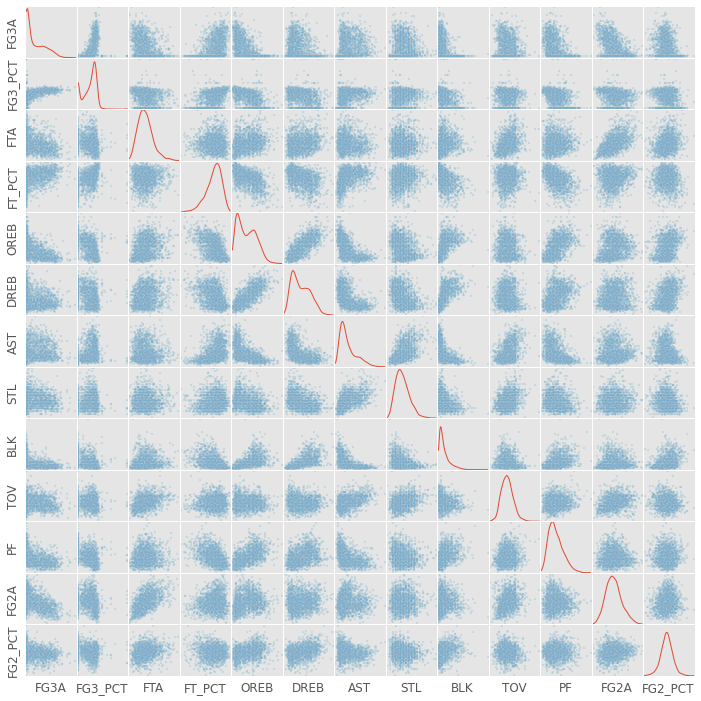

In [7]:
axs = pd.tools.plotting.scatter_matrix(df, alpha=0.2, figsize=(12, 12), diagonal='kde'); #the diagonal will show kernel density
[ax.set_yticks([]) for ax in axs[:,0]] #turn off the ticks that take up way too much space in such a crammed figure
[ax.set_xticks([]) for ax in axs[-1,:]];

There are a couple things to note in the graph above. First, there's a TON of information there. Second, it looks like there are some strong correlations. For example, look at the subplots depicting offensive rebounds by defensive rebounds.

While I tried to throw out redundant data, I clearly did not throw out all redundant data. For example, players that are good 3-point shooters are probably also good free throw shooters. These players are simply good shooters, and being a good shooter contributes to multiple data columns above. 

When I group the data, I do not want an ability such as shooting to contribute too much. I want to group players equally according to all their abilities. Below I use a PCA to seperate variance associated with the different "components" (e.g., shooting ability) of basketball performance.

For an explanation of PCA I recommend this link - https://georgemdallas.wordpress.com/2013/10/30/principal-component-analysis-4-dummies-eigenvectors-eigenvalues-and-dimension-reduction/. 

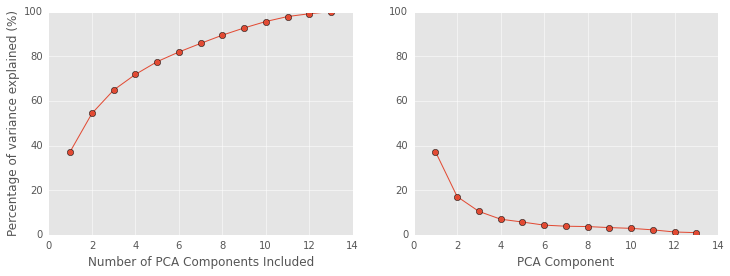

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

X = df.as_matrix() #take data out of dataframe
X = scale(X) #standardize the data before giving it to the PCA. 
#I standardize the data because some features such as PF or steals have lower magnitudes than other features such as FG2A
#I want both to contribute equally to the PCA, so I make sure they're on the same scale.

pca = PCA() #great PCA object
pca.fit(X) #pull out principle components
var_expl = pca.explained_variance_ratio_ #find amount of variance explained by each component
tot_var_expl = np.array([sum(var_expl[0:i+1]) for i,x in enumerate(var_expl)]) #create vector with cumulative variance

plt.figure(figsize=(12,4)) #create cumulative proportion of variance plot
plt.subplot(1,2,1)
plt.plot(range(1,len(tot_var_expl)+1), tot_var_expl*100,'o-')
plt.axis([0, len(tot_var_expl)+1, 0, 100])
plt.xlabel('Number of PCA Components Included')
plt.ylabel('Percentage of variance explained (%)')

plt.subplot(1,2,2) #create scree plot
plt.plot(range(1,len(var_expl)+1), var_expl*100,'o-')
plt.axis([0, len(var_expl)+1, 0, 100])
plt.xlabel('PCA Component');

On the left, I plot the amount of variance explained after including each additional PCA component. Using all the components explains all the variability, but notice how little the last few components contribute. It doesn't make sense to include a component that only explains 1% of the variability...but how many components to include!?

I chose to include the first 5 components because no component after the 5th explained more than 5% of the data. This part of the analysis is admittedly arbitrary, but 5% is a relatively conservative cut-off. 

Below is the fun part of the data. We get to look at what features contribute to the different principle components (greater values mean a feature contribute more to the principle component). Each principle component is a row and each column is a different feature.

* Assists and 3-point shooting contribute to the first component. I will call this the <strong>Outside Skills</strong> component. 
* Free throw attempts, assists, turnovers and 2-point field goals contribute to the second component. I will call this the <strong>Rim Scoring</strong> component.
* Free throw percentage and 2-point field goal percentage  contribute to the third component. I will call this the <strong>Pure Points</strong> component.
* 2-point field goal percentage and steals contribute to the fourth component. I will call this the <strong>Defensive Big Man</strong> component.
* 3-point shooting and free throws contribute to the fifth component. I will call this the <strong>Dead Eye</strong> component.

One thing to keep in mind here is that each component explains less variance than the last. So while 3 point shooting contributes to both the 1st and 5th component, more 3 point shooting variability is probably explained by the 1st component. 

It would be great if we had a PCA component that was only shooting and another that was only rebounding since we typically conceive these to be different skills. Yet, there are multiple aspects of each skill. For example, a 3-point shooter not only has to be a dead-eye shooter, but also has to find ways to get open. Additionally, being good at "getting open" might be something akin to basketball IQ which would also contribute to assists and steals!



In [9]:
factor_names = ['Outside Skills','Rim Scoring','Pure Points','Defensive Big Man','Dead Eye'] #my component names
loadings_df = pd.DataFrame(pca.components_, columns=df.columns)
loadings_df[0:5] #all the factor loadings appear below.

,FG3A,FG3_PCT,FTA,FT_PCT,OREB,DREB,AST,STL,BLK,TOV,PF,FG2A,FG2_PCT
0,0.321506,0.320929,-0.137827,0.288127,-0.414188,-0.368314,0.312043,0.197567,-0.341307,0.038788,-0.302558,-0.090183,-0.174199
1,-0.271638,-0.131264,0.466679,0.086695,0.012204,-0.071757,0.306964,0.281692,-0.093162,0.506950,0.005162,0.485509,0.058126
2,0.081277,0.223501,0.281449,0.412681,0.001659,0.142971,-0.186244,-0.345386,0.017632,-0.255977,-0.403291,0.324247,0.431144
3,-0.012076,0.003643,-0.151055,-0.138015,0.004676,0.138542,0.287597,0.441416,0.177912,-0.001267,-0.182245,-0.301243,0.711044
4,0.484921,0.358494,0.278203,-0.027049,0.013008,0.302193,0.000929,-0.170477,0.239647,0.537719,0.141084,-0.265262,-0.028485


Cool, we have our 5 PCA components. Now lets transform the data into our 5 component PCA space (from our 13 feature space - e.g., FG3A, FG3_PCT, ect.). To do this, we give each player a score on each of the 5 PCA components. 

Next, I want to see how players cluster together based on their scores on these components. First, let's investigate how using more or less clusters (i.e., groups) explains different amounts of variance.

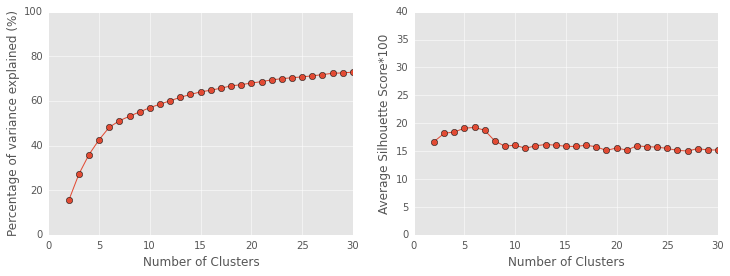

In [10]:
from scipy.spatial.distance import cdist, pdist, euclidean
from sklearn.cluster import KMeans
from sklearn import metrics


#http://stackoverflow.com/questions/6645895/calculating-the-percentage-of-variance-measure-for-k-means
#The above link was helpful when writing this code.

reduced_data = PCA(n_components=5, whiten=True).fit_transform(X) #transform data into the 5 PCA components space
#kmeans assumes clusters have equal variance, and whitening helps keep this assumption.

k_range = range(2,31) #looking amount of variance explained by 1 through 30 cluster
k_means_var = [KMeans(n_clusters=k).fit(reduced_data) for k in k_range] #fit kmeans with 1 cluster to 30 clusters

#get labels and calculate silhouette score
labels = [i.labels_ for i in k_means_var]
sil_score = [metrics.silhouette_score(reduced_data,i,metric='euclidean') for i in labels]

centroids = [i.cluster_centers_ for i in k_means_var] #get the center of each cluster
k_euclid = [cdist(reduced_data,cent,'euclidean') for cent in centroids] #calculate distance between each item and each cluster center
dist = [np.min(ke,axis=1) for ke in k_euclid] #get the distance between each item and its cluster

wcss = [sum(d**2) for d in dist] #within cluster sum of squares
tss = sum(pdist(reduced_data)**2/reduced_data.shape[0]) #total sum of squares
bss = tss-wcss #between cluster sum of squares

plt.clf()
plt.figure(figsize=(12,4)) #create cumulative proportion of variance plot
plt.subplot(1,2,1)
plt.plot(k_range, bss/tss*100,'o-')
plt.axis([0, np.max(k_range), 0, 100])
plt.xlabel('Number of Clusters')
plt.ylabel('Percentage of variance explained (%)');

plt.subplot(1,2,2) #create scree plot
plt.plot(k_range, np.transpose(sil_score)*100,'o-')
plt.axis([0, np.max(k_range), 0, 40])
plt.xlabel('Number of Clusters');
plt.ylabel('Average Silhouette Score*100');

As you can in the left hand plot, adding more clusters explains more of the variance, but there are diminishing returns. Each additional cluster explains a little less data than the last (much like each PCA component explained less variance than the previous component). 

The particularly intersting point here is the point where the second derivative is greatest, when the amount of change changes the most (the elbow). The elbow occurs at the 6th cluster.

Perhaps not coincidently, 6 clusters also has the highest silhouette score (right hand plot). The silhouette score computes the average distance between a player and all other players in this player's cluster. It then divides this distance by the distance between this player and all players in the next nearest cluster. Silhouette scores range between -1 and 1 (where negative one means the player is in the wrong cluster, 0 means the clusters completely overlap, and 1 means the clusters are extermely well separated).

Six clusters has the highest silhouette score at 0.19. 0.19 is not great, and suggests a different clustering algorithm might be better. More on this later.

Because 6 clusters is the elbow and has the highest silhouette score, I will use 6 clusters in my grouping analysis. Okay, now that I decided on 6 clusters lets see what players fall into what clusters!

In [11]:
final_fit = KMeans(n_clusters=6).fit(reduced_data) #fit 6 clusters
df['kmeans_label'] = final_fit.labels_ #label each data point with its clusters
df['PLAYER_ID'] = saveIDs #of course we want to know what players are in what cluster
player_names = [pd.DataFrame(players_df[players_df['PERSON_ID']==x]['DISPLAY_LAST_COMMA_FIRST']).to_string(header=False,index=False) for x in df['PLAYER_ID']]
# because playerID #s mean nothing to me, lets get the names too
df['Name'] = player_names

#lets also create a dataframe with data about where the clusters occur in the 5 component PCA space.
cluster_locs = pd.DataFrame(final_fit.cluster_centers_,columns=['component %s'% str(s) for s in range(np.size(final_fit.cluster_centers_,1))])
cluster_locs.columns = factor_names

df.head()

,FG3A,FG3_PCT,FTA,FT_PCT,OREB,DREB,AST,STL,BLK,TOV,PF,FG2A,FG2_PCT,kmeans_label,PLAYER_ID,Name
0,0.0,0.000,3.6,0.701,3.2,6.3,1.0,0.8,0.8,2.8,5.4,13.9,0.503597,5,76001,"Abdelnaby, Alaa"
1,0.0,0.056,5.8,0.721,1.9,5.9,3.5,0.7,2.0,1.6,2.9,17.7,0.559322,5,76003,"Abdul-Jabbar, Kareem"
2,3.1,0.354,2.7,0.905,0.5,2.0,4.8,1.1,0.1,2.2,2.5,15.2,0.460526,1,51,"Abdul-Rauf, Mahmoud"
3,0.6,0.237,4.0,0.703,2.1,3.7,2.0,1.4,0.6,2.3,3.6,12.3,0.430894,1,1505,"Abdul-Wahad, Tariq"
4,0.6,0.297,6.2,0.810,2.3,5.4,2.6,1.0,0.8,2.7,2.9,13.8,0.478261,5,949,"Abdur-Rahim, Shareef"


Awesome. Now lets see how all the clusters look. These clusters were created in 5 dimensional space, which is not easy to visualize. Below I plot another scatter matrix. The scatter matrix allows us to visualize the clusters in different 2D combinations of the 5D space. 

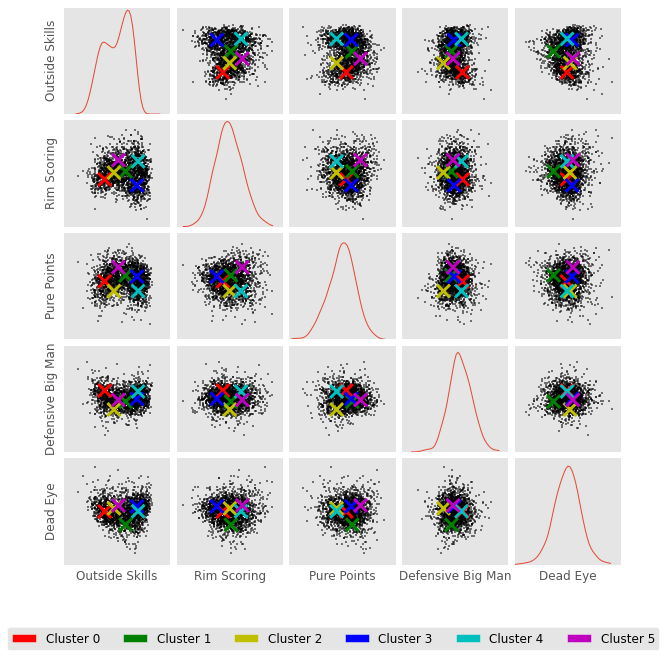

In [12]:
from scipy.stats import gaussian_kde
plt.clf()

centroids = final_fit.cluster_centers_ #find centroids so we can plot them
colors = ['r','g','y','b','c','m'] #cluster colors
Clusters = ['Cluster 0','Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5'] #cluster...names

numdata, numvars = reduced_data.shape #players by PCA components
fig, axes = plt.subplots(nrows=numvars, ncols=numvars, figsize=(10,10)) #create a scatter matrix with 5**2 cells
fig.subplots_adjust(hspace=0.05, wspace=0.05)

recs=[]
for col in colors: #make some patches for the legend
    recs.append(mpl.patches.Rectangle((0,0),1,1,fc=col))

fig.legend(recs,Clusters,8,ncol=6) #create legend with patches above

for i,ax in enumerate(axes.flat):
    # Hide all ticks and labels
    plt.setp(ax.get_yticklabels(), visible=False) #tick labels are too much with this many subplots
    plt.setp(ax.get_xticklabels(), visible=False)
    ax.grid(False) #again, too much
    if i%5==0:ax.set_ylabel(factor_names[i/5]) #label outer y axes
    if i>19:ax.set_xlabel(factor_names[i-20]) #label outer x axes
    
for i, j in zip(*np.triu_indices_from(axes, k=1)):
    for x, y in [(i,j), (j,i)]:
        #plot individual data points and cluster centers
        axes[y,x].plot(reduced_data[:, x], reduced_data[:, y], 'k.', markersize=2)
        axes[y,x].scatter(centroids[:,x], centroids[:,y],marker='x',s=169,linewidth=3,color=colors, zorder=10)
        
#create kernel density estimation for each PCA factor on the diagonals
for i, label in enumerate(factor_names):
    density = gaussian_kde(reduced_data[:,i]) 
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    x = np.linspace(min(reduced_data[:,i]),max(reduced_data[:,1]))
    axes[i,i].plot(x,density(x))
    


In this plot above. I mark the center of a given cluster with an X. For example, Cluster 0 and Cluster 5 are both high in outside skills. Cluster 5 is also high in rim scoring, but low in pure points. 

Below I look at the players in each cluster. The first thing I do is identify the player closest to the cluster's center. I call this player the prototype. It is the player that most exemplifies a cluster. 

I then show a picture of this player because... well I wanted to see who these players were. 
I print out this player's stats and the cluster's centroid location. 
Finally, I print out the first ten players in this cluster. This is the first ten players alphabetically. Not the ten players closest to cluster center. 

In [13]:
from IPython.display import display
from IPython.display import Image

name = player_names[np.argmin([euclidean(x,final_fit.cluster_centers_[0]) for x in reduced_data])] #find cluster prototype
PlayerID = str(int(df[df['Name']==name]['PLAYER_ID'])) #get players ID number
#player = Image(url = "http://stats.nba.com/media/players/230x185/"+PlayerID+".png")
player = Image(url = 'http://4.bp.blogspot.com/_RaOrchOImw8/S3mNk3exLeI/AAAAAAAAdZk/Hs-81mnXO_E/s400/Lloyd+Daniels.jpg',width=100)
display(player) 
display(df[df['Name']==name]) #prototype's stats
display(cluster_locs[0:1]) #cluster centroid location
df[df['kmeans_label']==0]['Name'][:10] #first ten players in the cluster (alphabetically)

,FG3A,FG3_PCT,FTA,FT_PCT,OREB,DREB,AST,STL,BLK,TOV,PF,FG2A,FG2_PCT,kmeans_label,PLAYER_ID,Name
1203,0,0,3.1,0.621,3.5,6,2,0.9,1.9,2.1,4.5,9.3,0.494624,0,77136,"Johnson, Clemon"


,Outside Skills,Rim Scoring,Pure Points,Defensive Big Man,Dead Eye
0,-1.274838,-0.46813,-0.128489,0.88836,-0.025318


7            Acres, Mark
8            Acy, Quincy
13         Adams, Steven
15          Adrien, Jeff
21        Ajinca, Alexis
26         Aldrich, Cole
34     Alexander, Victor
45       Alston, Derrick
51         Amundson, Lou
52       Andersen, Chris
Name: Name, dtype: object

First, let me mention that cluster number is a purely categorical variable. Not ordinal. If you run this analysis, you will likely create clusters with similar players, but in a different order. For example, your cluster 1 might be my cluster 0. 

Cluster 0 has the most players (25%; about 490 of the 1965 in this cluster analysis) and is red in the scatter matrix above. 

Cluster 0 players are second highest in outside shooting (in the table above you can see their average score on the outside skills component is 0.83). These players are lowest in rim scoring (-0.93), so they do not draw many fouls - they are basically the snipers from the outside. 

The prototype is Lloyd Daniels who takes a fair number of 3s. I wouldn't call 31% a dominant 3-point percentage, but its certainly not bad. Notably, Lloyd Daniels doesn't seem to do much but shoot threes, as 55% of his shots come from the great beyond. 

Cluster 0 notable players include Andrea Bargnani, JJ Barea, Danilo Gallinari, and Brandon Jennings. Some forwards. Some Guards. Mostly good shooters. 

On to Cluster 1... I probably should have made a function from this code, but I enjoyed picking the players pictures too much.

In [14]:
name = player_names[np.argmin([euclidean(x,final_fit.cluster_centers_[1]) for x in reduced_data])]
PlayerID = str(int(df[df['Name']==name]['PLAYER_ID']))
#player = Image(url = "http://stats.nba.com/media/players/230x185/"+PlayerID+".png")
player = Image(url = 'https://allshookdown.files.wordpress.com/2009/06/laettner_200_921121.jpg?w=200&h=300',width=100)
display(player)
display(df[df['Name']==name])
display(cluster_locs[1:2])
df[df['kmeans_label']==1]['Name'][:10]

,FG3A,FG3_PCT,FTA,FT_PCT,OREB,DREB,AST,STL,BLK,TOV,PF,FG2A,FG2_PCT,kmeans_label,PLAYER_ID,Name
2527,0.4,0.191,3.2,0.801,1.2,2.5,2.8,1,0.4,1.8,4,11.4,0.491228,1,28,"West, Doug"


,Outside Skills,Rim Scoring,Pure Points,Defensive Big Man,Dead Eye
1,0.092059,0.127736,0.369722,-0.34868,-1.268832


2      Abdul-Rauf, Mahmoud
3       Abdul-Wahad, Tariq
5           Abernethy, Tom
10           Adams, Hassan
14         Addison, Rafael
24            Alarie, Mark
27      Aldridge, LaMarcus
31     Alexander, Courtney
35           Alford, Steve
37            Allen, Lavoy
Name: Name, dtype: object

Cluster 1 is green in the scatter matrix and includes about 14% of players. 

Cluster 1 is highest on the rim scoring, pure points, and Dead Eye components. These players get the ball in the hoop. 

Christian Laettner is the prototype. He's a solid scoring forward. 

Gilbert Arenas stands out in the first ten names as I was tempted to think of this cluster as big men, but it really seems to be players who shoot, score, and draw fouls. 

Cluster 1 Notable players include James Harden,Kevin Garnet, Kevin Durant, Tim Duncan, Kobe, Lebron, Kevin Martin, Shaq, Anthony Randolph??, Kevin Love, Derrick Rose, and Michael Jordan.

In [15]:
name = player_names[np.argmin([euclidean(x,final_fit.cluster_centers_[2]) for x in reduced_data])]
PlayerID = str(int(df[df['Name']==name]['PLAYER_ID']))
#player = Image(url = "http://stats.nba.com/media/players/230x185/"+PlayerID+".png")
player = Image(url = 'http://imageocd.com/images/nba10/doug-west-wallpaper-height-weight-position-college-high-school/doug-west.jpg',width=100)
display(player)
display(df[df['Name']==name])
display(cluster_locs[2:3])
df[df['kmeans_label']==2]['Name'][:10]

,FG3A,FG3_PCT,FTA,FT_PCT,OREB,DREB,AST,STL,BLK,TOV,PF,FG2A,FG2_PCT,kmeans_label,PLAYER_ID,Name
674,0.3,0,3.7,0.709,2.6,4,2.6,0.7,1.2,2.4,3.9,7.8,0.397436,2,346,"Edwards, Doug"


,Outside Skills,Rim Scoring,Pure Points,Defensive Big Man,Dead Eye
2,-0.669812,0.03869,-0.943598,-1.241309,0.262218


17           Ager, Maurice
28        Aleksinas, Chuck
33          Alexander, Joe
36           Allen, Jerome
48           Amaechi, John
49           Amaya, Ashraf
74           Anstey, Chris
82          Araujo, Rafael
89      Armstrong, Brandon
101            Austin, Ike
Name: Name, dtype: object

Cluster 2 is yellow in the scatter matrix and includes about 17% of players. 

Lots of big men who are not outside shooters and don't draw many fouls. These players are strong 2 point shooters and free throw shooters. I think of these players as mid-range shooters. Many of the more recent Cluster 2 players are forwards since mid-range guards do not have much of a place in the current NBA. 

Cluster 2's prototype is Doug West. Doug West shoots well from the free throw line and on 2-point attempts, but not the 3-point line. He does not draw many fouls or collect many rebounds. 

Cluster 2 noteable players include LaMarcus Aldridge, Tayshaun Prince, Thaddeus Young, and Shaun Livingston

In [16]:
name = player_names[np.argmin([euclidean(x,final_fit.cluster_centers_[3]) for x in reduced_data])]
PlayerID = str(int(df[df['Name']==name]['PLAYER_ID']))
#player = Image(url = "http://stats.nba.com/media/players/230x185/"+PlayerID+".png")
player = Image(url = 'http://4.bp.blogspot.com/_f5MWZq1BJXI/TCDRy3v6m9I/AAAAAAAAACc/Ux8M7uiadoc/s400/cato.jpg',width=100)
display(player)
display(df[df['Name']==name])
display(cluster_locs[3:4])
df[df['kmeans_label']==3]['Name'][:10]

,FG3A,FG3_PCT,FTA,FT_PCT,OREB,DREB,AST,STL,BLK,TOV,PF,FG2A,FG2_PCT,kmeans_label,PLAYER_ID,Name
534,4.9,0.316,2.1,0.743,1.9,2.6,3.2,1,0.6,2.1,3,9,0.455556,3,1380,"Daniels, Lloyd"


,Outside Skills,Rim Scoring,Pure Points,Defensive Big Man,Dead Eye
3,0.835607,-0.918818,0.282577,-0.053005,0.44777


16       Afflalo, Arron
20         Ainge, Danny
40           Allen, Ray
46        Alston, Rafer
50     Aminu, Al-Farouq
53      Andersen, David
54       Anderson, Alan
56      Anderson, Derek
60      Anderson, James
63       Anderson, Kyle
Name: Name, dtype: object

Cluster 3 is blue in the scatter matrix and includes about 16% of players.  

Cluster 3 players do not have outside skills such as assists and 3-point shooting (they're last in outside skills). They do not draw many fouls or shoot well from the free throw line. These players do not shoot often, but have a decent shooting percentage. This is likely because they only shoot when wide open next to the hoop. 

Cluster 3 players are highest on the defensive big man component. They block lots of shots and collect lots of rebounds. 

The Cluster 3 prototype is Kelvin Cato. Cato is not and outside shooter and he only averages 7.5 shots per 36, but he makes these shots at a decent clip. Cato averages about 10 rebounds per 36. 

Notable Cluster 3 players include Andrew Bogut, Tyson Chandler, Andre Drummond, Kawahi Leonard??, Dikembe Mutumbo, and Hassan Whiteside. 

In [17]:
name = player_names[np.argmin([euclidean(x,final_fit.cluster_centers_[4]) for x in reduced_data])]
PlayerID = str(int(df[df['Name']==name]['PLAYER_ID']))
#player = Image(url = "http://stats.nba.com/media/players/230x185/"+PlayerID+".png")
player = Image(url = 'http://www.thenolookpass.com/wp-content/uploads/2012/01/IMG-724x1024.jpg', width=100) #a photo just for fun
display(player)
display(df[df['Name']==name])
display(cluster_locs[4:5])
df[df['kmeans_label']==4]['Name'][:10]

TypeError: cannot convert the series to <type 'int'>

Cluster 4 is cyan in the scatter matrix above and includes the least number of players (about 13%). 

Cluster 4 players are not high on outsize skills. They are average on rim scoring. They do not score many points, and they don't fill up the defensive side of the stat sheet. These players don't seem like all stars.

Looking at Doug Edwards' stats - certainly not a 3-point shooter. I guess a good description of cluster 4 players might be ... NBA caliber bench warmers. 

Cluster 4's notable players include Yi Jianlian and Anthony Bennet....yeesh

In [30]:
name = player_names[np.argmin([euclidean(x,final_fit.cluster_centers_[5]) for x in reduced_data])]
#PlayerID = str(int(df[df['Name']==name]['PLAYER_ID']))
PlayerID = str(76993) #Two Gerald Hendersons!
#player = Image(url = "http://stats.nba.com/media/players/230x185/"+PlayerID+".png", width=100)
player = Image(url = 'http://cdn.fansided.com/wp-content/blogs.dir/18/files/2014/04/b__gerald_henderson_82.jpg', width=100)
display(player)
#display(df[df['PLAYER_ID']==76993])
display(cluster_locs[5:])
df[df['kmeans_label']==5]['Name'][:10]

,Outside Skills,Rim Scoring,Pure Points,Defensive Big Man,Dead Eye
5,-0.386045,0.973199,1.059723,-0.166625,0.53358


0              Abdelnaby, Alaa
1         Abdul-Jabbar, Kareem
4         Abdur-Rahim, Shareef
9                 Adams, Alvan
18               Aguirre, Mark
75      Antetokounmpo, Giannis
77            Anthony, Carmelo
85             Arenas, Gilbert
121                 Baker, Vin
133           Barkley, Charles
Name: Name, dtype: object

Cluster 5 is magenta in the scatter matrix and includes 16% of players. 

Cluster 5 players are highest in outside skills and second highest in rim scoring yet these players are dead last in pure points. It seems they score around the rim, but do not draw many fouls. They are second highest in defensive big man. 

Gerald Henderson Sr is the prototype. Henderson is a good 3 point and free throw shooter but does not draw many fouls. He has lots of assists and steals. 

Of interest mostly because it generates an error in my code, Gerald Henderson Jr is in cluster 2 - the mid range shooters. 

Notable cluster 5 players include Mugsy Bogues, MCW, Jeff Hornacek, Magic Johnson, Jason Kidd, Steve Nash, Rajon Rando, John Stockton. Lots of guards. 

In the cell below, I plot the percentage of players in each cluster. 

In [ ]:
plt.clf()
plt.hist(df['kmeans_label'], normed=True,bins=[0,1,2,3,4,5,6],rwidth = 0.5)
plt.xticks([0.5,1.5,2.5,3.5,4.5,5.5],['Group 0','Group 1','Group 2','Goup 3','Group 4','Group 5'])
plt.ylabel('Percentage of Players in Each Cluster');

I began this post by asking whether player positions is the most natural way to group NBA players. The clustering analysis here suggests not. 

Here's my take on the clusters: Cluster 0 is pure shooters, Cluster 1 is talented scorers, Cluster 2 is mid-range shooters, Cluster 3 is defensive big-men, Cluster 4 is bench warmers, Cluster 5 is distributors. We might call the "positions" shooters, scorers, rim protectors, and distributors.

It's possible that our notion of position comes more from defensive performance than offensive. On defense, a player must have a particular size and agility to guard a particular opposing player. Because of this, a team will want a range of sizes and agility - strong men to defend the rim and quick men to defend agile ball carriers. Box scores are notoriously bad at describing defensive performance. This could account for the lack of "positions" in my cluster.

I did not include player height and weight in this analysis. I imagine height and weight might have made clusters that resemble the traditional positions. I chose to not include height and weight because these are player attributes; not player performance. 

After looking through all the groups one thing that stands out to me is the lack of specialization. For example we did not find a single cluster of incredible 3-point shooters. Cluster 1 includes many great shooters, but it's not populated exclusively by great shooters. It would be interesting if adding additional clusters to the analysis could find more specific clusters such as big-men that can shoot from the outside (e.g., Dirk) or high-volume scorers (e.g., Kobe).

I tried to list some of the aberrant cluster choices in the notable players to give you an idea for the amount of error in the clustering. These aberrant choices are not errors, they are simply an artifact of how k-means defines clusters. Using a different clustering algorithm would produce different clusters. On that note, the silhouette score of this clustering model is not great, yet the clustering algorithm definitely found similar players, so its not worthless. Nonetheless, clusters of NBA players might not be spherical. This would prevent a high silhouette score. Trying a different algorithm without the spherical clusters assumption would definitely be worthwhile. 

Throughout this entire analysis, I was tempted to think about group membership, as a predictor of a player's future performance. For instance, when I saw Karl Anthony Towns in the same cluster as Kareem Abdul-Jabbar, I couldn't help but think this meant good things for Karl Anthony Towns. Right now, this doesn't seem justified. No group included less than 10% of players so not much of an oppotunity for a uniformly "star" group to form. Each group contained some good and some bad players. Could more clusters change this? I plan on examining whether more clusters can improve the clustering algorithm's ability to find clusters of exclusively quality players. If it works, I'll post it here.  



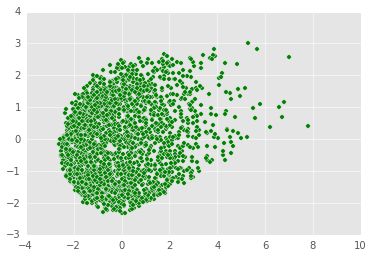

In [24]:
Z = final_fit.fit_transform(reduced_data)
X = final_fit.predict(reduced_data)
from sklearn import manifold

mds = manifold.MDS(n_components=2, max_iter=3000, dissimilarity="euclidean")
pos = mds.fit(Z).embedding_
plt.scatter(pos[:, 0], pos[:, 1], s=20, c='g')

In [26]:
print np.size(Z,0)
print np.size(pos,0)

1965
1965


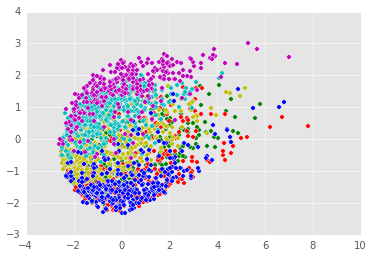

In [29]:
X = final_fit.predict(reduced_data)
plt.scatter(pos[X==0][:, 0], pos[X==0][:, 1], s=20, c='g')
plt.scatter(pos[X==1][:, 0], pos[X==1][:, 1], s=20, c='r')
plt.scatter(pos[X==2][:, 0], pos[X==2][:, 1], s=20, c='y')
plt.scatter(pos[X==3][:, 0], pos[X==3][:, 1], s=20, c='c')
plt.scatter(pos[X==4][:, 0], pos[X==4][:, 1], s=20, c='b')
plt.scatter(pos[X==5][:, 0], pos[X==5][:, 1], s=20, c='m')
